In [1]:
import itertools
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from math import floor
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#DATA PRE-PROCESSING

In [3]:
df = pd.read_json("../products_all.jl", lines=True)
df = df.rename(columns={'n_reviews': 't_reviews', 'm_reviews': 'n_reviews'})

In [4]:
dr = df[['url','reviews_url']]
df = df.drop(['url', 'reviews_url', 'discount_price'], 1)

df = df[df['t_reviews']>0]

In [5]:
df.loc[df['genres'].isna(), 'genres'] = df['tags']
df['genres'].dropna()
df['genres'] = [str(x) for x in df['genres']]
df['specs'] = [str(x) for x in df['specs']]
df['tags'] = [str(x) for x in df['tags']]
df['platform'] = [str(x) for x in df['platform']]
df['release_date'] = [str(x) for x in df['release_date']]

In [6]:
df=df.sort_values('id', ascending=True)
df.reset_index(drop=True, inplace=True)
#df.head()

In [7]:
df['price'] = df['price'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
df = df.drop(['metascore'], 1)
#df.head()

In [8]:
#Function to calculate game rating based on steamDB's formula
def ratings(row):
    pos = row['p_reviews']
    average = pos / row['t_reviews']
    
    rating = average - (average*0.5) * 2**(-math.log10(row['t_reviews']+1))
    return rating * 100

#Separating genres into columns, values 0s and 1s
def genres_split(d):
    cols = ['Action', 'Adventure', 'Casual', 'Indie', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
    g_cols = []
    for i in sorted(cols):
        col = i.lower().replace(' ','_')
        g_cols.append(col)
        d[col] = np.where(d['genres'].str.contains(i), 1, 0)

    g = d[g_cols].sum(axis=1)
    d = d[g > 0].copy()
    
    return d


#Adding columns for single_player and multi_player categories
def play_split(d):
    tags_col = ['Multiplayer', 'Massively Multiplayer']
    specs_col = ['Online PvP', 'Cross-Platform Multiplayer']
    #splitting on basis of multiplayer tags
    for i, j in zip(tags_col, specs_col):
        d.loc[d['tags'].str.contains(i), 'multi_player'] = 1
        d.loc[d['specs'].str.contains(j), 'multi_player'] = 1
    
    #splitting on basis of singleplayer tags
    d.loc[d['tags'].str.contains('Singleplayer'), 'single_player'] = 1
    d.loc[d['specs'].str.contains('Single-player'), 'single_player'] = 1
    
    #filling NaN values with 0
    d['single_player'] = d['single_player'].fillna(0)
    d['multi_player'] = d['multi_player'].fillna(0)
    return d

def platform(d):
    os = ['mac', 'win', 'linux']
    for i in os:
        d.loc[d['platform'].str.contains(i), i] = 1
    for i in os:
        d[i] = d[i].fillna(0)
    return d

In [9]:
#Calculate ratings based on SteamDB's forumla
df['rating'] = df.apply(ratings, axis=1)

#Separating genres into columns, values 0s and 1s
df = genres_split(df)
df.drop(['genres'], 1)

#Extracting Release Year from Date of Release
df['release_year'] = df['release_date'].str.extract(r'(\d{4})')
df = df[pd.notnull(df['release_year'])]
df['release_year'] = [int(x) for x in df['release_year']]

#Confine dataset to prices below USD$100
df.loc[df.price > 100, 'price'] = np.nan
df = df.dropna(subset=['price'])

#Categorizing games based on price, 'Free To Play' and 'Paid'
df['type'] = 'Free To Play'
df.loc[df.price > 0, 'type'] = 'Paid'

#Rearranging columns
r_col = ['id', 'title', 'developer', 'publisher', 'release_date', 'release_year', 'genres', 'rating', 't_reviews', 'p_reviews', 'n_reviews', 'price', 'type', 'sentiment', 'platform', 'specs', 'tags', 'early_access', 'action', 'adventure', 'casual', 'indie', 'rpg', 'racing', 'simulation', 'sports', 'strategy']
df = df[r_col]

#Adding columns for single_player and multi_player categories
df = play_split(df)
df['single_player'] = [int(x) for x in df['single_player']]
df['multi_player'] = [int(x) for x in df['multi_player']]

#Splitting platforms
df = platform(df)

In [10]:
df.loc[df['single_player']==1, 'category'] = 'Single Player'
df.loc[df['multi_player']==1, 'category'] = 'Multi Player'

In [11]:
df.loc[df['mac']==1, 'platform_support'] = 'Mac'
df.loc[df['win']==1, 'platform_support'] = 'Windows'
df.loc[df['linux']==1, 'platform_support'] = 'Linux'
df.loc[(df['mac']==1) & (df['linux']==1), 'platform_support'] = 'Mac+Linux'
df.loc[(df['win']==1) & (df['linux']==1), 'platform_support'] = 'Win+Linux'
df.loc[(df['mac']==1) & (df['win']==1), 'platform_support'] = 'Win+Mac'
df.loc[(df['mac']==1) & (df['linux']==1) & (df['win']==1), 'platform_support'] = 'Win+Mac+Linux'

In [12]:
df['platform_support'].value_counts()

Windows          27021
Win+Mac+Linux     7392
Win+Mac           5595
Win+Linux          925
Mac                  3
Linux                1
Name: platform_support, dtype: int64

In [13]:
df['multi_player'].value_counts()

0    33375
1     8179
Name: multi_player, dtype: int64

In [14]:
colors_duo = ['#1C387B', '#45ACBF']
colors_set = ['#184D68', '#31809F', '#8fba25', '#d9f895', '#FB9C6C', '#D55121']

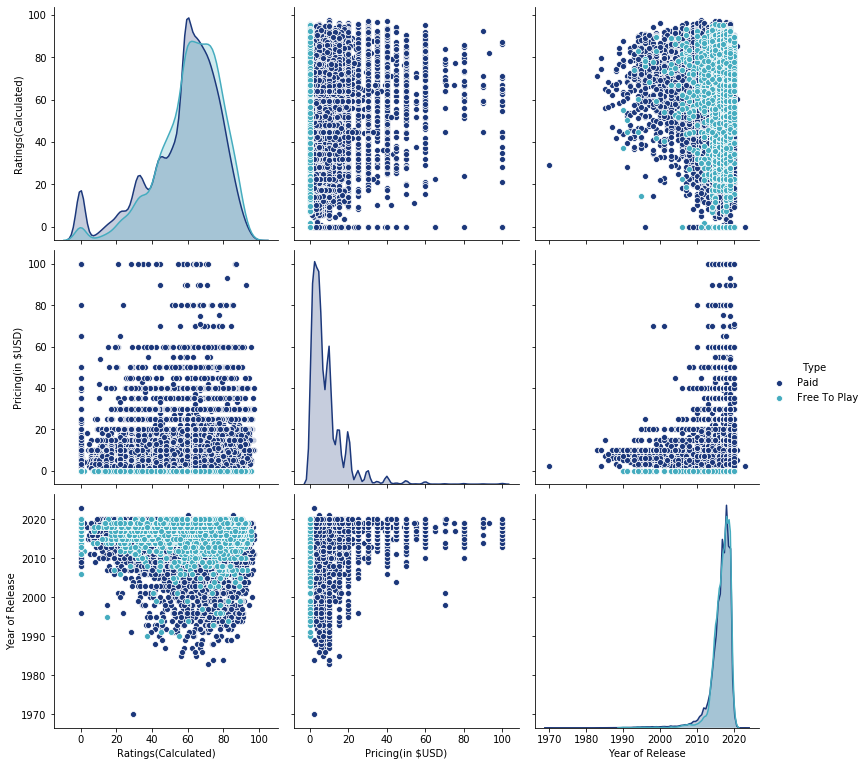

In [16]:
#PairPlot Graph on type
ds = pd.DataFrame(zip(df['rating'], df['price'], df['release_year'], df['type']), columns=['Ratings(Calculated)', 'Pricing(in $USD)', 'Year of Release', 'Type'])
sns.pairplot(ds, hue='Type', height=3.5, palette=colors_duo)
plt.show()

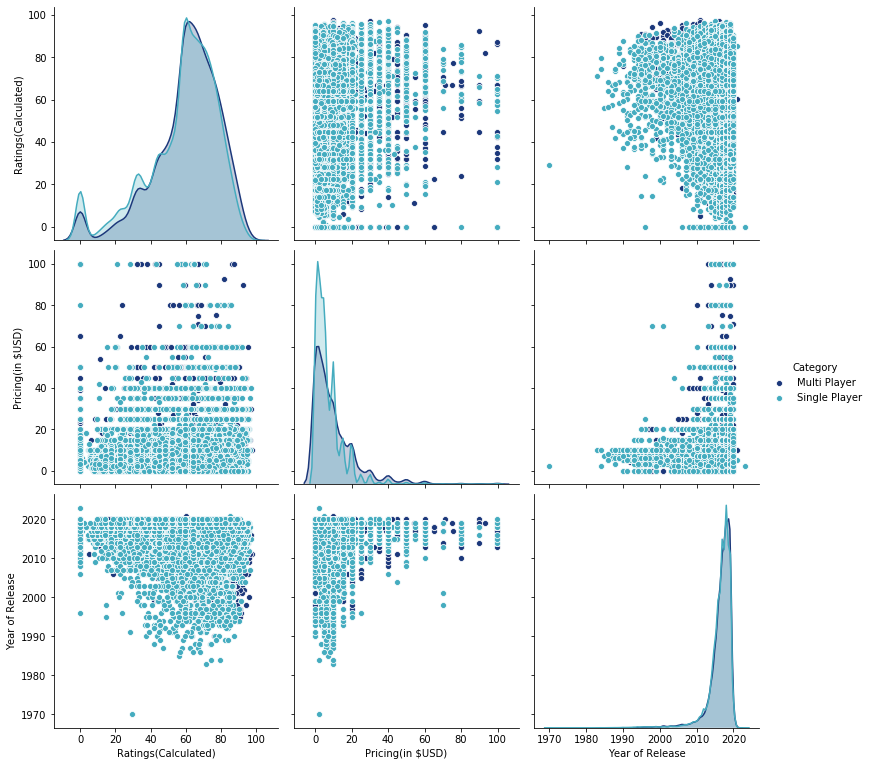

In [17]:
#PairPlot Graph
ds = pd.DataFrame(zip(df['rating'], df['price'], df['release_year'], df['category']), columns=['Ratings(Calculated)', 'Pricing(in $USD)', 'Year of Release', 'Category'])
sns.pairplot(ds, hue='Category', height=3.5, palette=colors_duo)
plt.show()

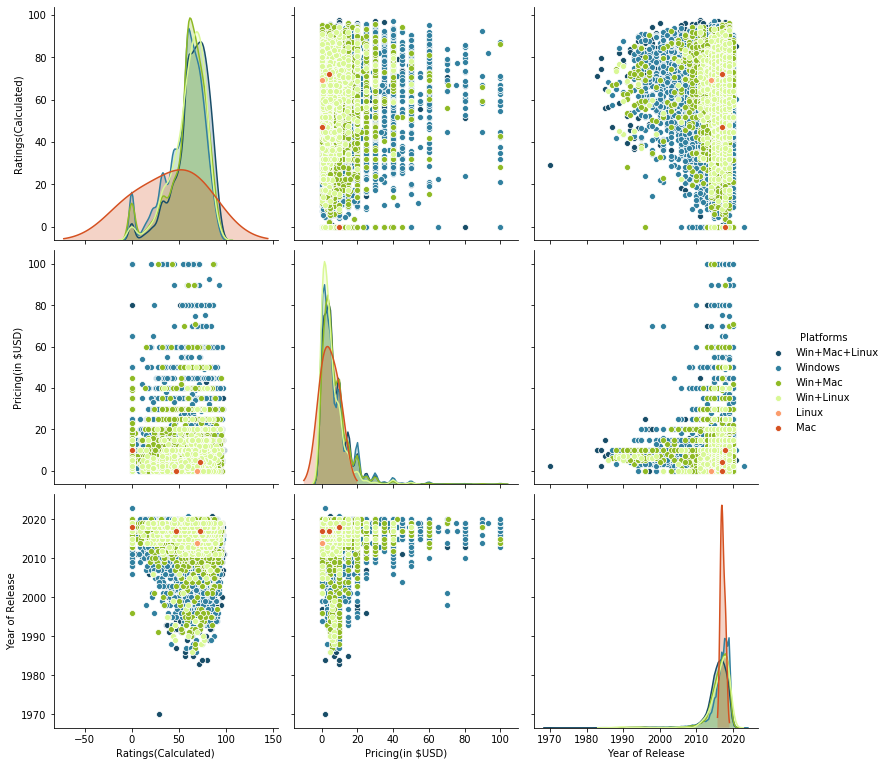

In [18]:
#PairPlot Graph
ds = pd.DataFrame(zip(df['rating'], df['price'], df['release_year'], df['platform_support']), columns=['Ratings(Calculated)', 'Pricing(in $USD)', 'Year of Release', 'Platforms'])
sns.pairplot(ds, hue='Platforms', height=3.5, palette=colors_set)
plt.show()

In [19]:
def decade(x):
    return str(floor(x/10)*10)+"s"

In [20]:
dz = pd.DataFrame(zip(df['rating'], df['release_year'], df['category'], df['platform_support'], df['type']), columns=['rating', 'release_year', 'category', 'platforms', 'type'])
dz['decade'] = dz['release_year'].apply(decade)
dz = dz.sort_values('release_year', ascending=True)

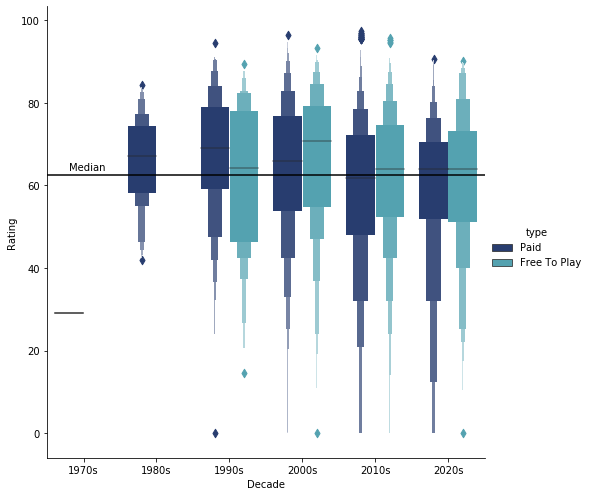

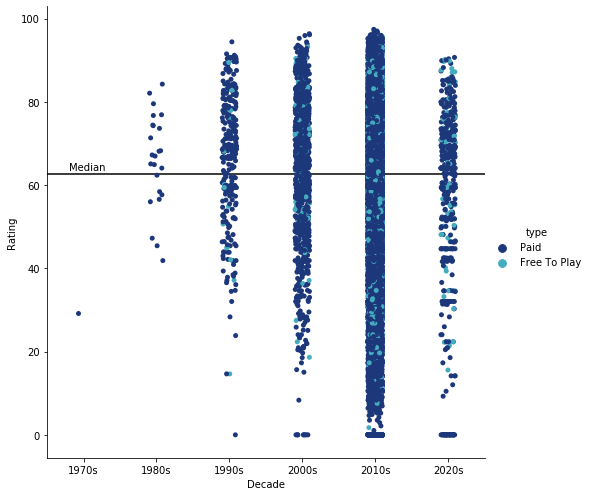

In [22]:
sns.catplot("decade", "rating", "type", data=dz, kind="boxen", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
sns.catplot("decade", "rating", "type", data=dz, kind="strip", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
plt.show()

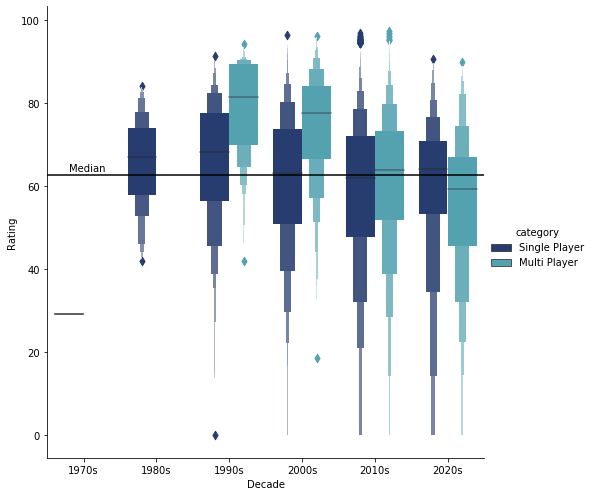

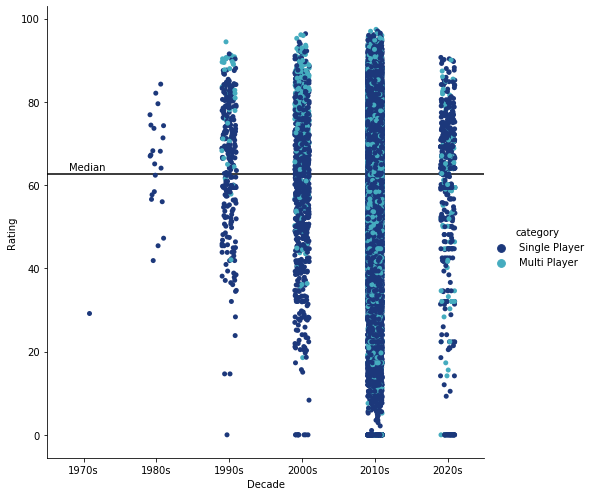

In [23]:
sns.catplot("decade", "rating", "category", data=dz, kind="boxen", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
sns.catplot("decade", "rating", "category", data=dz, kind="strip", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
plt.show()

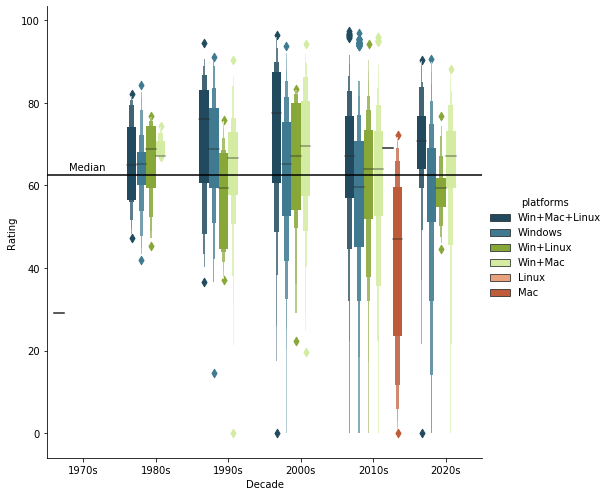

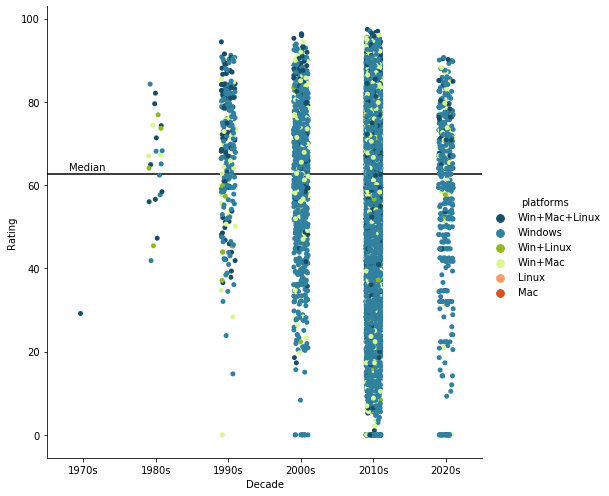

In [24]:
sns.catplot("decade", "rating", "platforms", data=dz, kind="boxen", height=7, palette=colors_set).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
sns.catplot("decade", "rating", "platforms", data=dz, kind="strip", height=7, palette=colors_set).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
plt.show()

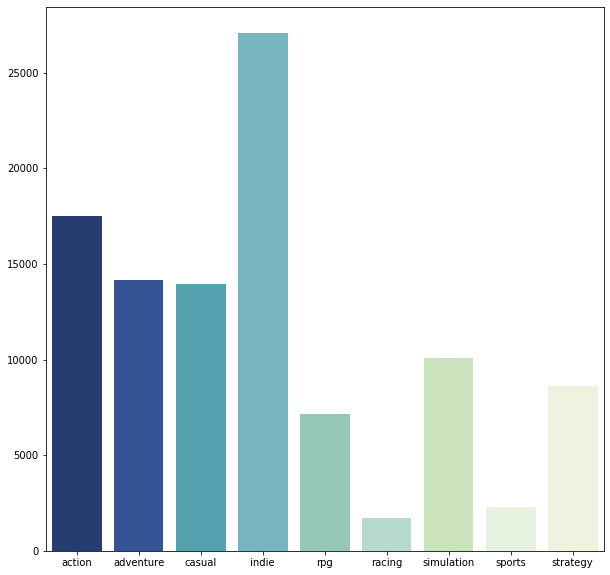

In [25]:
col_genres = df.columns[-16:-7]
colors = ['#2A692D', '#317B35', '#388E3C', '#3FA044', '#8BC34A','#97C95D', '#DCE775', '#BFD962', '#FFF59D', '#FFF8B7', '#0099CC']
colors_b = ['#1C387B','#254ba5','#45ACBF','#6bbdcc','#8CD1BB','#b0e0d1','#CAEAB5','#e6f5dd','#f2f5dd']
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=col_genres ,y=df[col_genres].sum(), ax=ax, palette = colors_b)
plt.show()

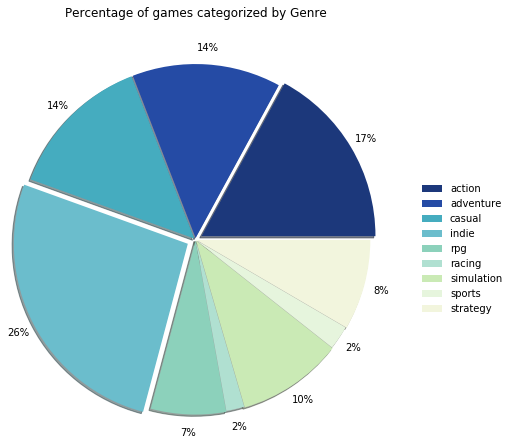

In [26]:
sizes = []
for x in df[col_genres].sum():
    sizes.append(x)

fig1, ax1 = plt.subplots()
explode = (0.08, 0.02, 0.02, 0.1, 0.01, 0, 0.01, 0, 0.01)
ax1.pie(sizes, explode=explode, autopct='%1.0f%%', colors = colors_b, shadow=True, pctdistance=1.1, radius=2)

ax1.legend(labels = col_genres, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title("Percentage of games categorized by Genre", y=1.5, x=0.5)
plt.show()

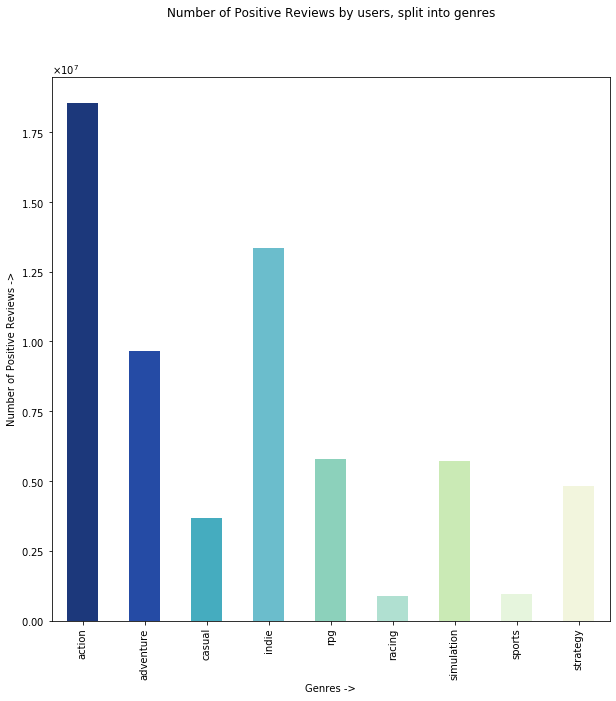

In [27]:
fig2, ax2 = plt.subplots(figsize=(10,10))
t_genre = df[col_genres].multiply(df['p_reviews'], axis='index').sum()
t1_genre = df[col_genres].multiply(df['t_reviews'], axis='index').sum()

t_genre.plot.bar(ax=ax2, color=colors_b)

plt.ticklabel_format(style='sci', axis='y', useMathText=True)
plt.xlabel("Genres ->")
plt.ylabel("Number of Positive Reviews ->")
plt.title("Number of Positive Reviews by users, split into genres", y=1.1)
plt.show()

In [28]:
#Including single_player and multi_player into genres
col_genres = df.columns[-16:-5]

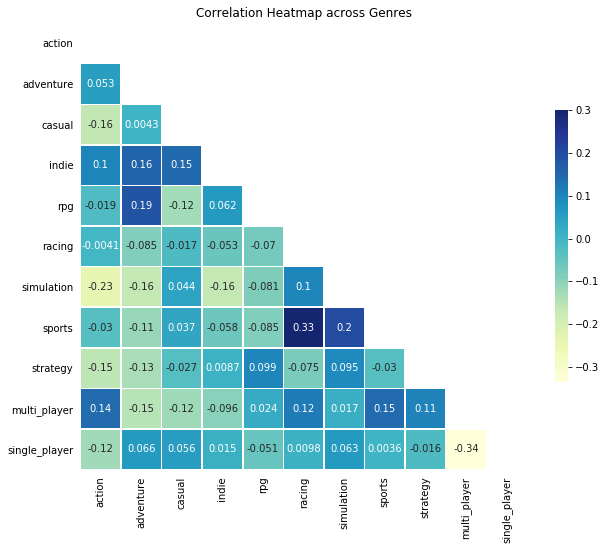

In [29]:
#Plotting correlation heatmap across Genres
corr = df[col_genres].corr()
#sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = "YlGnBu"
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
plt.title("Correlation Heatmap across Genres")
plt.show()